In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import itertools
%pip install Prophet  
!pip install pmdarima
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#read csv
df = pd.read_csv('selected_esp500_esg.csv')

Note: you may need to restart the kernel to use updated packages.


## Data Exploration

In [3]:
#quick data exploration
df.head()

,Date,Ticker,Close,High,Low,Open,Volume,Return,Total ESG Risk score
0,2024-01-09,A,128.743134,133.639472,128.083066,130.309579,1435000.0,NaN,13.6
1,2024-01-10,A,129.147049,129.216019,126.457516,128.644613,1326300.0,0.003137,13.6
2,2024-01-11,A,127.757919,128.743098,126.004311,128.644589,2060500.0,-0.010756,13.6
3,2024-01-12,A,128.605194,129.659342,127.718539,128.378607,1285200.0,0.006632,13.6
4,2024-01-16,A,128.595367,128.871216,126.693980,127.225970,1382100.0,-0.000076,13.6


In [4]:
df.tail()

,Date,Ticker,Close,High,Low,Open,Volume,Return,Total ESG Risk score
10055,2026-01-05,VLO,180.570007,184.979996,177.509995,179.690002,9056500.0,0.092311,32.6
10056,2026-01-06,VLO,178.270004,184.070007,177.250000,182.699997,5333000.0,-0.012737,32.6
10057,2026-01-07,VLO,183.860001,187.649994,183.070007,184.360001,7565700.0,0.031357,32.6
10058,2026-01-08,VLO,191.320007,192.000000,181.009995,184.110001,5959600.0,0.040574,32.6
10059,2026-01-09,VLO,185.190002,191.755005,182.610001,191.490005,3786340.0,-0.032041,32.6


In [5]:
df.shape

(10060, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10060 entries, 0 to 10059
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  10060 non-null  object 
 1   Ticker                10060 non-null  object 
 2   Close                 10060 non-null  float64
 3   High                  10060 non-null  float64
 4   Low                   10060 non-null  float64
 5   Open                  10060 non-null  float64
 6   Volume                10060 non-null  float64
 7   Return                10040 non-null  float64
 8   Total ESG Risk score  10060 non-null  float64
dtypes: float64(7), object(2)
memory usage: 707.5+ KB


## Cleaning and Preprocessing

In [8]:
#drop missing values
df_clean = df.dropna().copy()

In [9]:
#categorize stocks by esg risk score
esg_threshold = df_clean['Total ESG Risk score'].mean()

#create column risk group, map low risk if risk tot esg risk score < mean else high risk
df_clean['Risk Group'] = df_clean['Total ESG Risk score'].apply(
    lambda x: 'Low Risk ESG' if x < esg_threshold else 'High Risk ESG'
)

print("Risk Group Counts:")
print(df_clean['Risk Group'].value_counts())

Risk Group Counts:
Risk Group
Low Risk ESG     5020
High Risk ESG    5020
Name: count, dtype: int64


In [10]:
#dtypes
print(df_clean.dtypes)

Date                     object
Ticker                   object
Close                   float64
High                    float64
Low                     float64
Open                    float64
Volume                  float64
Return                  float64
Total ESG Risk score    float64
Risk Group               object
dtype: object


## Summary Stats

In [12]:
#for numerical columns:
df_clean[['Close', 'Volume', 'Return', 'Total ESG Risk score']].describe()

,Close,Volume,Return,Total ESG Risk score
count,10040.000000,1.004000e+04,10040.000000,10040.00000
mean,130.195320,3.267063e+06,0.000758,22.80000
std,94.512294,2.465469e+06,0.019283,11.00582
min,23.803688,3.584000e+05,-0.241971,10.70000
25%,63.733771,1.869150e+06,-0.008229,11.82500
50%,110.023670,2.645500e+06,0.000903,22.05000
75%,152.927917,3.887525e+06,0.010019,33.00000
max,547.721313,6.634010e+07,0.262130,37.30000


In [13]:
#for return by risk group:
df_clean.groupby('Risk Group')['Return'].describe().T

Risk Group,High Risk ESG,Low Risk ESG
count,5020.000000,5020.000000
mean,0.000826,0.000691
std,0.020039,0.018497
min,-0.241971,-0.177211
25%,-0.008480,-0.007951
50%,0.000954,0.000849
75%,0.010595,0.009295
max,0.262130,0.191121


## Exploratory Plots

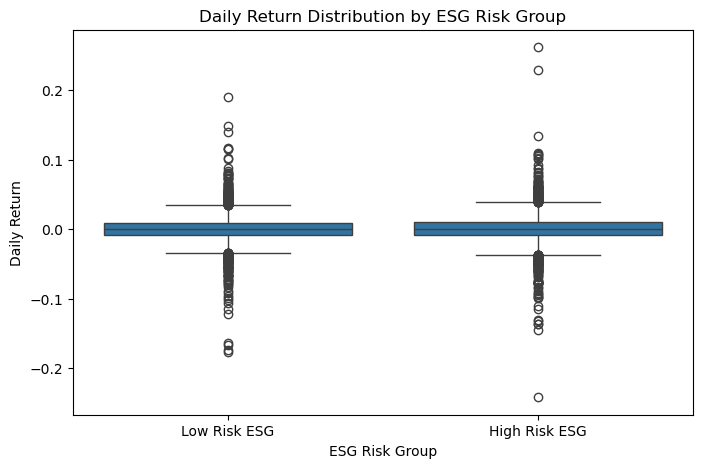

In [15]:
#box plot shows return distribution by esg risk group
plt.figure(figsize=(8, 5))
sns.boxplot(x='Risk Group', y='Return', data=df_clean)
plt.title('Daily Return Distribution by ESG Risk Group')
plt.xlabel('ESG Risk Group')
plt.ylabel('Daily Return')
plt.show()

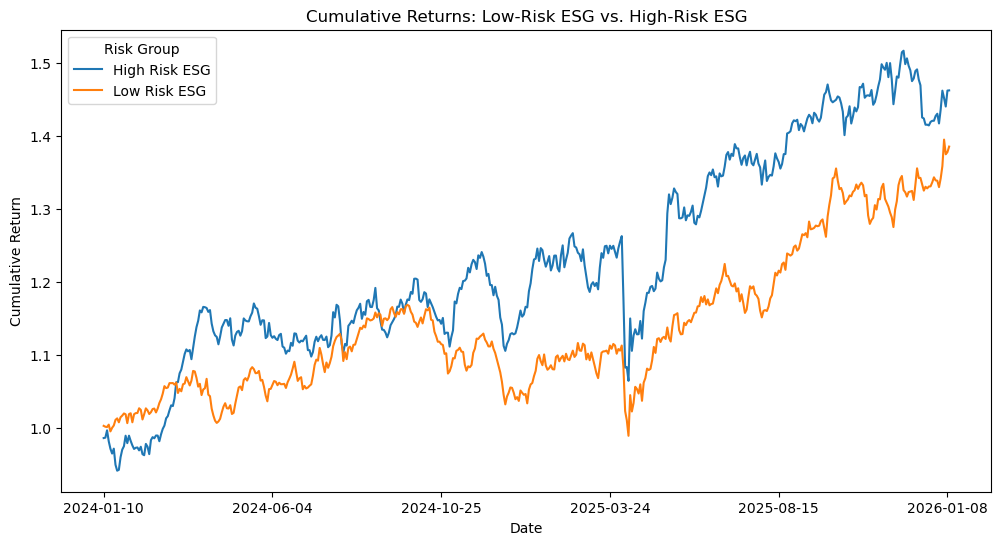

In [16]:
#plot time series cumulative returns by risk group
cumulative_returns = (1 + df_clean.groupby(['Date', 'Risk Group'])['Return'].mean()).unstack()
cumulative_returns = cumulative_returns.cumprod()

plt.figure(figsize=(12, 6))
cumulative_returns.plot(ax=plt.gca())
plt.title('Cumulative Returns: Low-Risk ESG vs. High-Risk ESG')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(title='Risk Group')
plt.show()

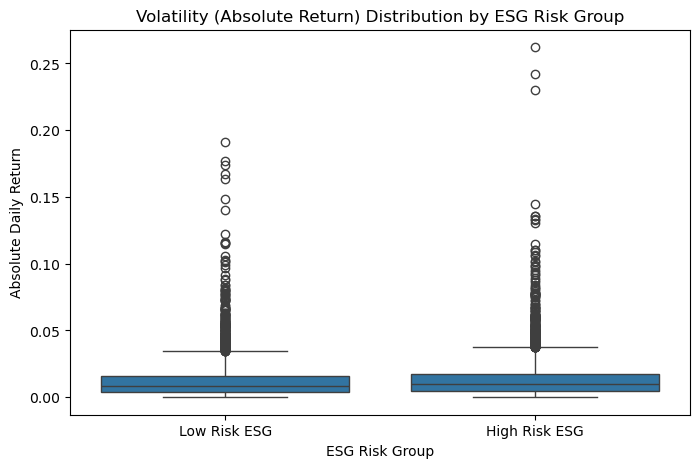

In [17]:
#box plot of volatility which is absolute return risk group
df_clean['Abs_Return'] = df_clean['Return'].abs()
plt.figure(figsize=(8, 5))
sns.boxplot(x='Risk Group', y='Abs_Return', data=df_clean)
plt.title('Volatility (Absolute Return) Distribution by ESG Risk Group')
plt.xlabel('ESG Risk Group')
plt.ylabel('Absolute Daily Return')
plt.show()

## Simple Linear Regression Model

In [19]:
X = df_clean[['Total ESG Risk score', 'Open', 'High', 'Low', 'Volume']]
y = df_clean['Return']

# train-test split. shuffle=false bc time series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False 
)

#initiaise lr model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#model eval
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Linear Regression Model Results:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Linear Regression Model Results:
Mean Squared Error (MSE): 0.00024091431826628467
Root Mean Squared Error (RMSE): 0.015521414828110376


In [20]:
#model coeffs (feature importance)
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("Model Coefficients (Impact on Return):")
print(coefficients)

Model Coefficients (Impact on Return):
                Feature   Coefficient
3                   Low  4.288583e-03
2                  High  3.185109e-03
0  Total ESG Risk score  5.449574e-05
4                Volume -2.663710e-10
1                  Open -7.464355e-03


In [21]:
#rscore

### Using Prophet Model

### Preparing high and low esg risk ratings

Prophet cannot handle multiple stocks in one dataframe (it is designed to handle a single ds-y combination not multiple y's(Close values for different tickers) for a single ds)

Steps:
1. Create 2 dataframes by selecting the low and high group.
2. Calculate average closing price per day and assign it to y variable
3. Run 2 seperate models for each dataset


In [24]:
#split the dataset into the two 
esg_low_risk = df_clean[df_clean['Risk Group'] == 'Low Risk ESG']
esg_high_risk = df_clean[df_clean['Risk Group'] == 'High Risk ESG']

#aggregate 
def create_index(df):
    #calculate avg closing price per day
    daily_avg = df.groupby('Date')['Close'].mean().reset_index()

    #rename to meet prophet requirements
    return daily_avg.rename(columns={'Date': 'ds', 'Close': 'y'})

#high and lower risk scores datasets for model input
high_risk_esg_prophet = create_index(esg_high_risk)
low_risk_esg_prophet = create_index(esg_low_risk)


In [25]:
high_risk_esg_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      502 non-null    object 
 1   y       502 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.0+ KB


#### Using Grid Search to select best parameters for Prophet Model

With Grid search, we test different combinations of two sets of parameters: changepoint_prior_scale (0.001, 0.01, 0.05, 0.1) and seasonality_mode (additive and multiplicative), to determine the best ones for the model based on the evaluation metrics (MAE and RMSE)

In [27]:
import pandas as pd
import numpy as np
import itertools
from prophet import Prophet
from sklearn.metrics import mean_squared_error

def get_best_params(training_data):
    """
    Performs grid search with simple train/test split to find best parameters.
    """
    
    #parameter grid
    param_grid = {  
        'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5,1.0],
        'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
        'seasonality_mode': ['additive', 'multiplicative'],
        'changepoint_range': [0.8, 0.9]
    }
    
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    
    #80/20 train/test split
    split_index = int(len(training_data) * 0.8)
    train = training_data.iloc[:split_index]
    test = training_data.iloc[split_index:]
    
    best_params = None
    best_rmse = float('inf')
    
    #looping parameter combinations
    for params in all_params:
        try:
            m = Prophet(**params, daily_seasonality=False)
            m.fit(train)
            
            forecast = m.predict(test[['ds']])
            rmse = np.sqrt(mean_squared_error(test['y'], forecast['yhat']))
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = params
                
        except Exception as e:
            continue
    
    print(f"Best RMSE: {best_rmse:.4f}")
    print(f"Best params: {best_params}")
    
    return best_params

In [28]:
def prophet(df, group_name, cap_factor=1.5):
    
    #ds to datetime format
    df['ds'] = pd.to_datetime(df['ds'])
    df = df.sort_values('ds').reset_index(drop=True)
    
    
    split_point = int(len(df) * 0.8)
    split_date = df.iloc[split_point]['ds']
    
    print(f"--- {group_name} Analysis ---")
    print(f"Total Data: {len(df)} | Split Date: {split_date.date()}")
    
    train_df = df[df['ds'] <= split_date]
    test_df = df[df['ds'] > split_date]
    
    #get best params
    print("  -> Finding best hyperparameters...")
    best_params = get_best_params(train_df)
    print(f"  -> Best Params: {best_params}")
    
    #train final model. unpack the dictionary using ** to feed params into prophet
    m = Prophet(**best_params) 
    m.fit(train_df)
    
    #predict
    forecast = m.predict(test_df[['ds']])
    
    #metrics
    y_true = test_df['y'].values
    y_pred = forecast['yhat'].values
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    
    return train_df, test_df, forecast, mae, rmse, best_params
    

In [29]:
def plot_prophet_results(train_df, test_df, forecast, mae, rmse, group_name):
    plt.figure(figsize=(14, 6))

    #training data
    plt.plot(train_df['ds'], train_df['y'], 'ko', markersize=3, label='Training Data')

    #test data
    plt.plot(test_df['ds'], test_df['y'], 'go', markersize=4, label='Test Data (Actual)')

    #forecast
    plt.plot(test_df['ds'], forecast['yhat'], 'r-', linewidth=2, label='Test Predictions')

    #uncertainty interval
    plt.fill_between(
        test_df['ds'],
        forecast['yhat_lower'],
        forecast['yhat_upper'],
        alpha=0.3,
        color='pink',
        label='Uncertainty'
    )

    # Train/Test split line
    plt.axvline(train_df['ds'].max(), color='blue', linestyle='--',
                linewidth=2, label='Train/Test Split')

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(
        f'{group_name} ESG – Prophet Performance '
        f'(MAE: {mae:.2f}, RMSE: {rmse:.2f})'
    )
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


--- High ESG Analysis ---
Total Data: 502 | Split Date: 2025-08-18
  -> Finding best hyperparameters...


00:08:41 - cmdstanpy - INFO - Chain [1] start processing
00:08:41 - cmdstanpy - INFO - Chain [1] done processing
00:08:41 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:08:41 - cmdstanpy - INFO - Chain [1] start processing
00:08:42 - cmdstanpy - INFO - Chain [1] done processing
00:08:42 - cmdstanpy - INFO - Chain [1] start processing
00:08:42 - cmdstanpy - INFO - Chain [1] done processing
00:08:42 - cmdstanpy - INFO - Chain [1] start processing
00:08:42 - cmdstanpy - INFO - Chain [1] done processing
00:08:42 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:08:43 - cmdstanpy - INFO - Chain [1] start processing
00:08:43 - cmdstanpy - INFO - Chain [1] done processing
00:08:43 - cmdstanpy - INFO - Chain [1] start processing
00:08:43 - cmdstanpy - INFO - Chain [1] done processing
00:08:43 - cmdstanpy - INFO - Chain [1] 

Best RMSE: 6.1269
Best params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}
  -> Best Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


00:09:22 - cmdstanpy - INFO - Chain [1] done processing


MAE: 8.92
RMSE: 9.36


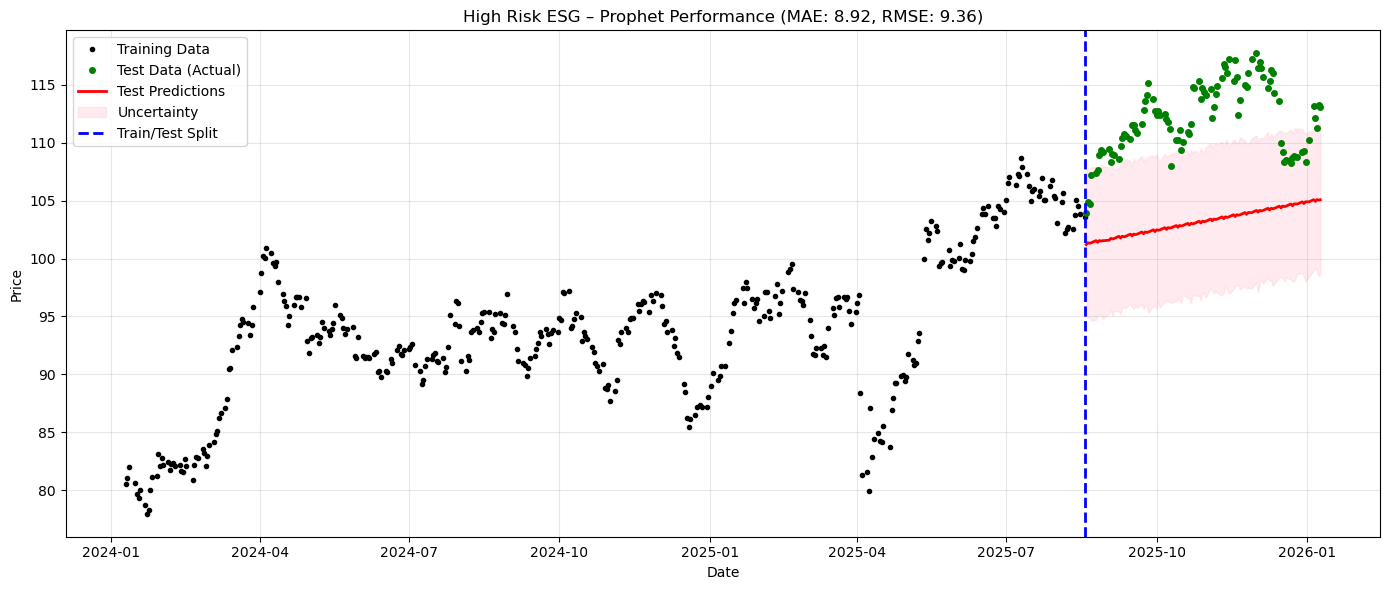

00:09:23 - cmdstanpy - INFO - Chain [1] start processing


--- Low ESG Analysis ---
Total Data: 502 | Split Date: 2025-08-18
  -> Finding best hyperparameters...


00:09:23 - cmdstanpy - INFO - Chain [1] done processing
00:09:23 - cmdstanpy - INFO - Chain [1] start processing
00:09:23 - cmdstanpy - INFO - Chain [1] done processing
00:09:23 - cmdstanpy - INFO - Chain [1] start processing
00:09:23 - cmdstanpy - INFO - Chain [1] done processing
00:09:24 - cmdstanpy - INFO - Chain [1] start processing
00:09:24 - cmdstanpy - INFO - Chain [1] done processing
00:09:24 - cmdstanpy - INFO - Chain [1] start processing
00:09:24 - cmdstanpy - INFO - Chain [1] done processing
00:09:24 - cmdstanpy - INFO - Chain [1] start processing
00:09:25 - cmdstanpy - INFO - Chain [1] done processing
00:09:25 - cmdstanpy - INFO - Chain [1] start processing
00:09:25 - cmdstanpy - INFO - Chain [1] done processing
00:09:25 - cmdstanpy - INFO - Chain [1] start processing
00:09:25 - cmdstanpy - INFO - Chain [1] done processing
00:09:25 - cmdstanpy - INFO - Chain [1] start processing
00:09:26 - cmdstanpy - INFO - Chain [1] done processing
00:09:26 - cmdstanpy - INFO - Chain [1] 

Best RMSE: 3.6952
Best params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}
  -> Best Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


00:09:59 - cmdstanpy - INFO - Chain [1] done processing


MAE: 15.89
RMSE: 17.11


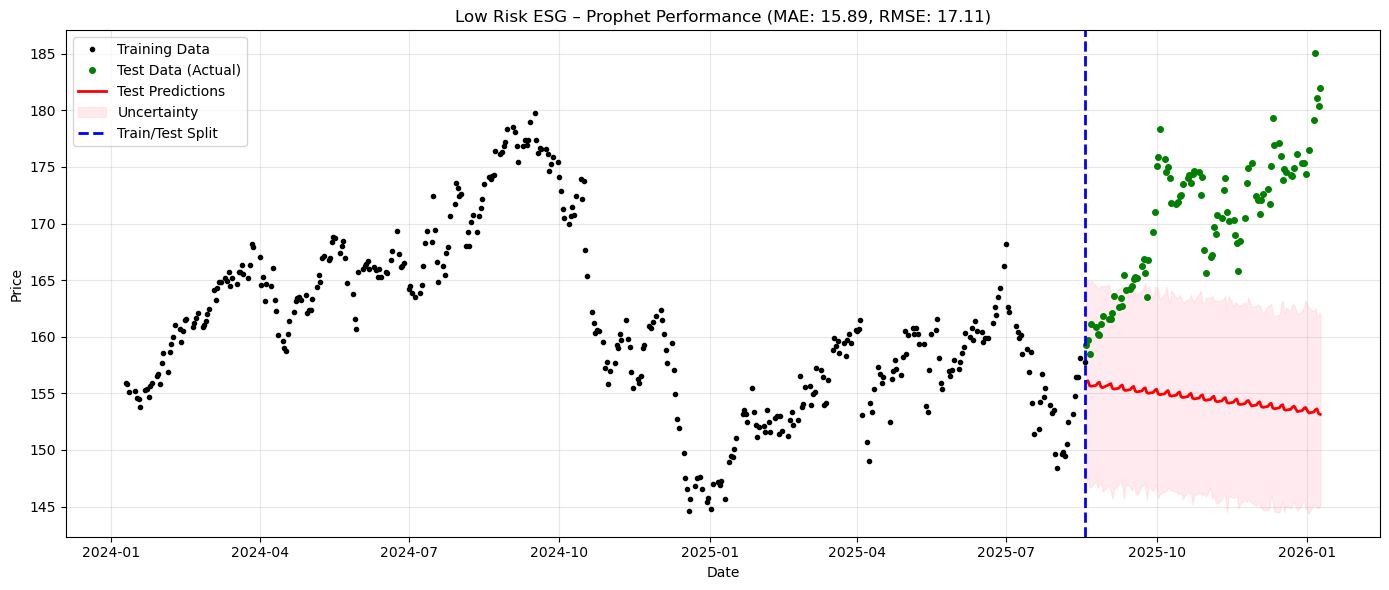

In [30]:
#high risk
train_h, test_h, forecast_h, mae_h, rmse_h, best_params_h = prophet(
    high_risk_esg_prophet, "High ESG"
)

plot_prophet_results(
    train_h, test_h, forecast_h, mae_h, rmse_h, "High Risk"
)

#low risk esg
train_l, test_l, forecast_l, mae_l, rmse_l, best_params_l = prophet(
    low_risk_esg_prophet, "Low ESG"
)

plot_prophet_results(
    train_l, test_l, forecast_l, mae_l, rmse_l, "Low Risk"
)


### Using ARIMA

In [32]:
#import required libraries
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

In [33]:
from pmdarima import auto_arima

def auto_arima_model(df, group_name):
    """
    Use auto_arima to automatically find best parameters.
    """
    df = df.copy()
    df['ds'] = pd.to_datetime(df['ds'])
    df = df.sort_values('ds').reset_index(drop=True)
    
    split_idx = int(len(df) * 0.8)
    train_series = df['y'].iloc[:split_idx]
    test_series = df['y'].iloc[split_idx:]

    #split dates
    train_dates = df['ds'].iloc[:split_idx]
    test_dates = df['ds'].iloc[split_idx:]
    
    print(f"--- {group_name} Auto-ARIMA Analysis ---")
    print("Searching for best parameters...")
    
    #Auto ARIMA - automatically finds best (p,d,q)
    model = auto_arima(
        train_series,
        start_p=0, max_p=7,
        start_q=0, max_q=7,
        max_d=2,  # Let it determine d automatically
        seasonal=False, 
        stepwise=True,  # Faster than exhaustive search
        suppress_warnings=True,
        error_action='ignore',
        trace=True,
        n_fits=50
    )

    best_order = model.order
    print(f"\nBest Order: {best_order}")
    print(f"AIC: {model.aic():.2f}")
    
    #pred
    predictions = model.predict(n_periods=len(test_series))
    
    mae = mean_absolute_error(test_series, predictions)
    rmse = np.sqrt(mean_squared_error(test_series, predictions))
    
    print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f}\n")
    
    return model, train_series, test_series, predictions, train_dates, test_dates, mae, rmse, best_order


--- High Risk ESG Group Auto-ARIMA Analysis ---
Searching for best parameters...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1358.957, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1360.183, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1360.254, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1357.738, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1361.940, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.186 seconds

Best Order: (0, 1, 0)
AIC: 1357.74
MAE: 8.19 | RMSE: 8.78

--- Low Risk ESG Group Auto-ARIMA Analysis ---
Searching for best parameters...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1484.003, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1485.825, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1485.848, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1482.008, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0

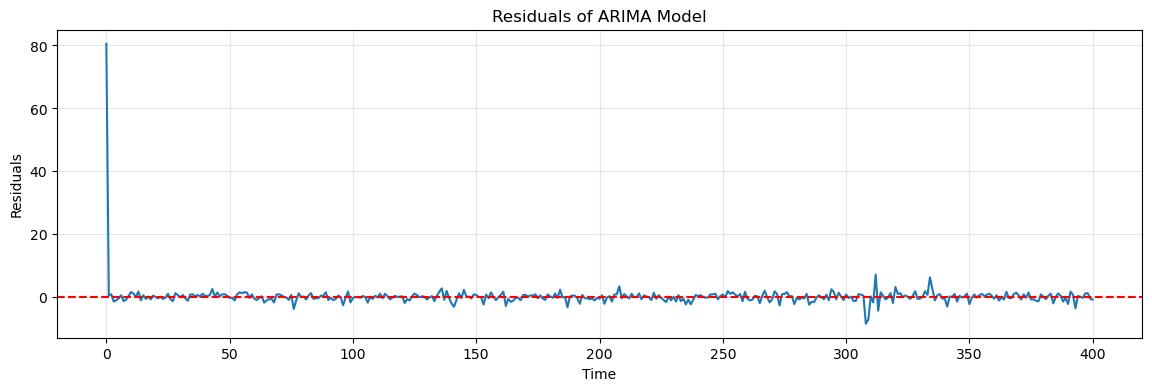

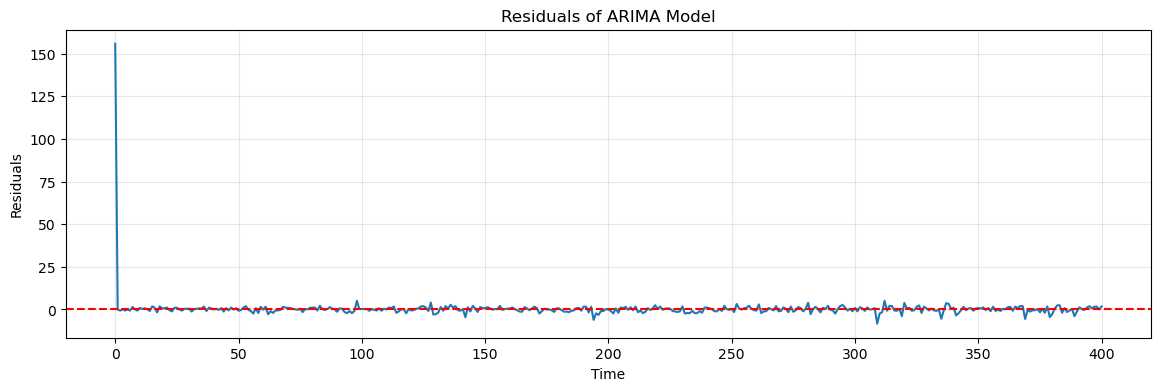

In [34]:
#run ARIMA model
model_h, train_h, test_h_arima, pred_h_arima, train_dates_h, test_dates_h, mae_h, rmse_h, best_order_h = auto_arima_model(high_risk_esg_prophet, "High Risk ESG Group")
model_l, train_l, test_l_arima, pred_l_arima, train_dates_l, test_dates_l, mae_l, rmse_l, best_order_l = auto_arima_model(low_risk_esg_prophet, "Low Risk ESG Group")


#plot residuals
residuals_h = model_h.resid()
plt.figure(figsize=(14, 4))
plt.plot(residuals_h)
plt.title('Residuals of ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True, alpha=0.3)
plt.show()

residuals_l = model_l.resid()
plt.figure(figsize=(14, 4))
plt.plot(residuals_l)
plt.title('Residuals of ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True, alpha=0.3)
plt.show()

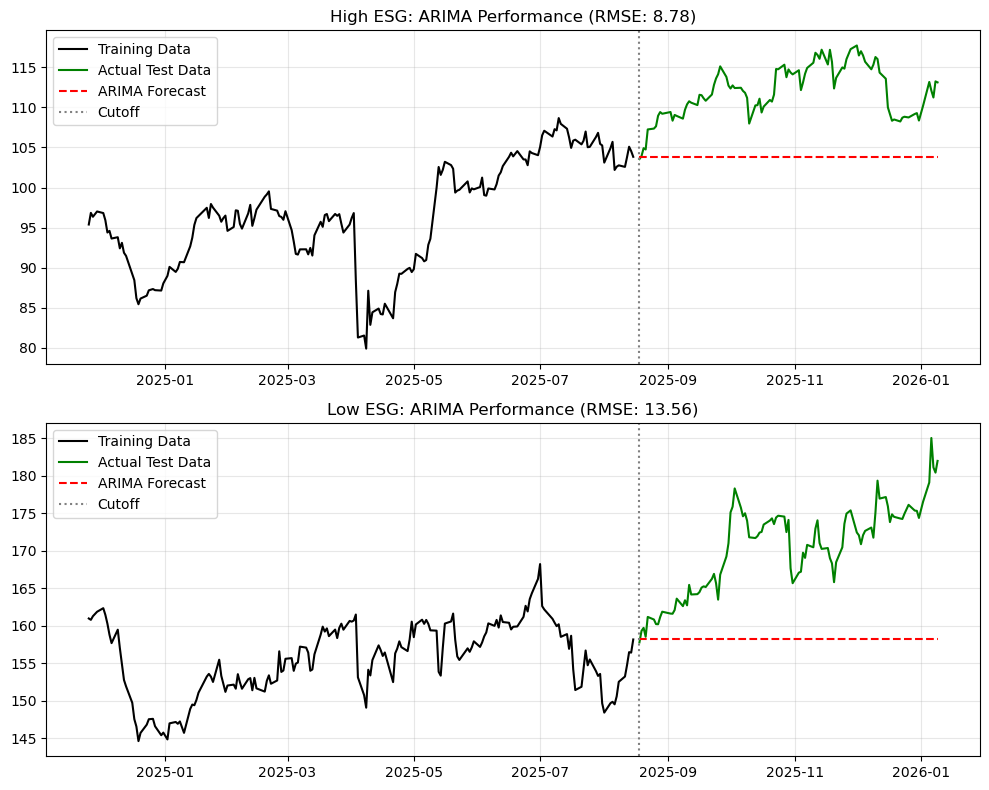

In [35]:
#visualise predictions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

#plot high risk esg group
ax1.plot(train_dates_h[-180:], train_h.values[-180:], label='Training Data', color='black')
ax1.plot(test_dates_h, test_h_arima.values, label='Actual Test Data', color='green')
ax1.plot(test_dates_h, pred_h_arima.values, label='ARIMA Forecast', color='red', linestyle='--')
ax1.axvline(x=test_dates_h.iloc[0], color='gray', linestyle=':', label='Cutoff')
ax1.set_title(f'High ESG: ARIMA Performance (RMSE: {rmse_h:.2f})')
ax1.legend()
ax1.grid(True, alpha=0.3)

##plot low risk esg group
ax2.plot(train_dates_l[-180:], train_l.values[-180:], label='Training Data', color='black')
ax2.plot(test_dates_l, test_l_arima.values, label='Actual Test Data', color='green')
ax2.plot(test_dates_l, pred_l_arima.values, label='ARIMA Forecast', color='red', linestyle='--')
ax2.axvline(x=test_dates_l.iloc[0], color='gray', linestyle=':', label='Cutoff')
ax2.set_title(f'Low ESG: ARIMA Performance (RMSE: {rmse_l:.2f})')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [36]:
type(train_h.index)

pandas.core.indexes.range.RangeIndex

### Using LSTM



In [38]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf


 Training LSTM for High ESG...


C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

RMSE: 3.07
MAE: 2.57

 Training LSTM for Low ESG...


C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

RMSE: 1.94
MAE: 1.42


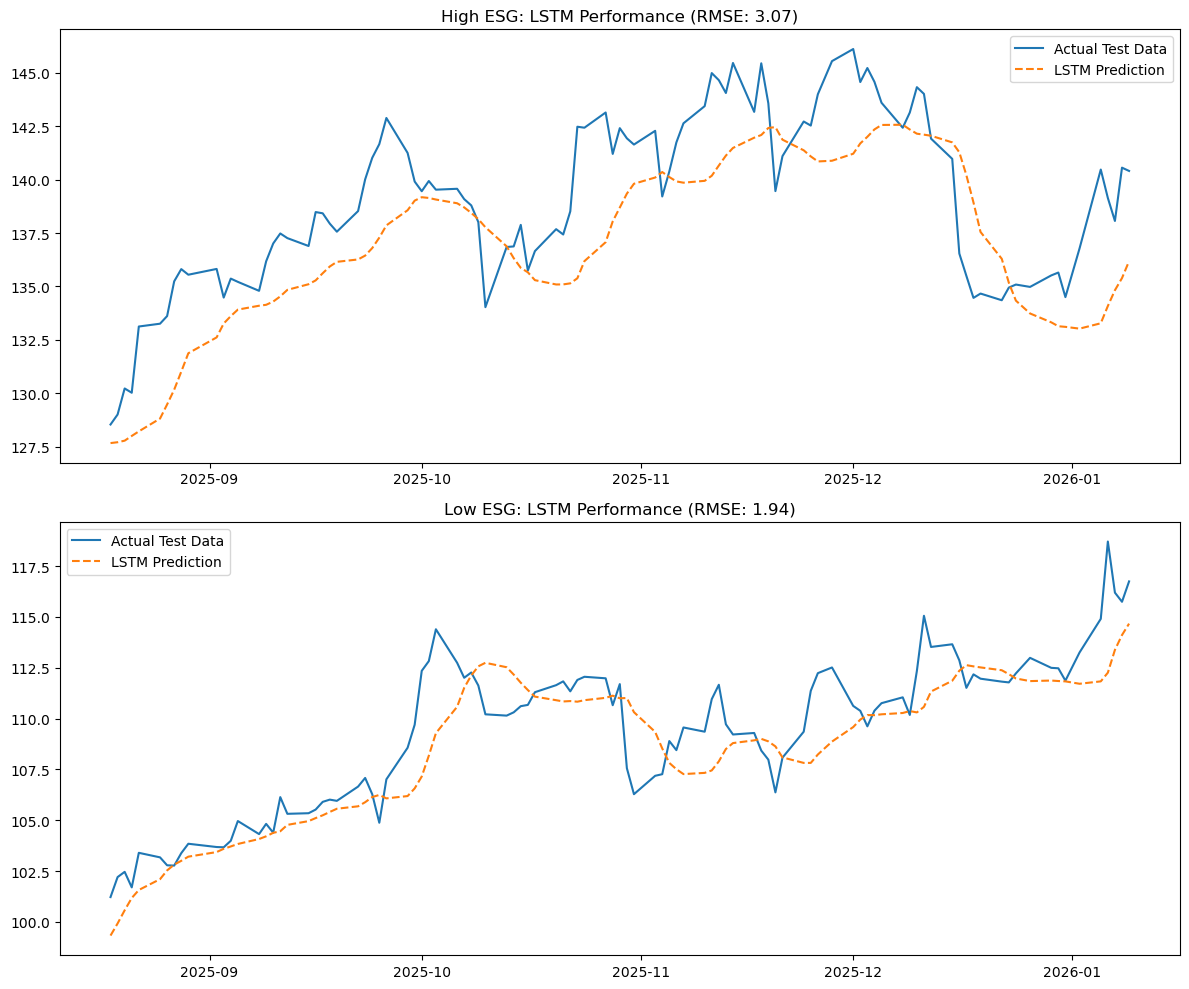

In [39]:
#set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

def prepare_series(group_df):
    daily = group_df.groupby('Date')['Close'].mean().reset_index()
    daily['Date'] = pd.to_datetime(daily['Date'])
    start_price = daily['Close'].iloc[0]

    series = (daily['Close'] / start_price) * 100
    dates = daily['Date']

    return series.values, dates


series_high, dates_high = prepare_series(esg_high_risk)
series_low, dates_low = prepare_series(esg_low_risk)

#sequence creation
def create_sequences(dataset, look_back=60):
    """
    Converts a list of numbers into "Windows"
    X = Past 60 days
    y = The next day
    """
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

def run_lstm_pipeline(series, dates, group_name, look_back=60):
    print(f"\n Training LSTM for {group_name}...")
    
    #scale data between 0-1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(series.reshape(-1, 1)) #reshape (rows, 1 feature)
    
    #train/test (80/20)
    training_size = int(len(scaled_data) * 0.8)
    train_data = scaled_data[0:training_size, :]
    test_data  = scaled_data[training_size - look_back:, :] #ensures we have context for the first test prediction
    
    #create sequences
    X_train, y_train = create_sequences(train_data, look_back)
    X_test, y_test = create_sequences(test_data, look_back)
    
    #reshape input as LSTM expects samples, time steps, features
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    #BUILD MODEL...
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1))) #50 neurons
    model.add(Dense(1)) #output layer ->predict 1 price
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    #train model
    model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=0)

    model.summary()
    
    #pred
    predictions = model.predict(X_test, verbose=0)
    
    #inverse scale from 0-1 back to original price values + inverse transform shape
    predictions = scaler.inverse_transform(predictions)
    actuals = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    #mae//rmse
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    
    #dates for test data
    test_dates = dates[training_size : training_size + len(actuals)]
    
    return test_dates, actuals, predictions, rmse

# run models
dates_h, actual_h, pred_h, rmse_h = run_lstm_pipeline(series_high, dates_high, "High ESG", look_back=60)
dates_l, actual_l, pred_l, rmse_l = run_lstm_pipeline(series_low, dates_high, "Low ESG", look_back=60)

#visualisation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))


#high risk esg
ax1.plot(dates_h, actual_h, label='Actual Test Data')
ax1.plot(dates_h, pred_h, label='LSTM Prediction', linestyle='--')
ax1.set_title(f'High ESG: LSTM Performance (RMSE: {rmse_h:.2f})')
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.legend()

#low risk esg
ax2.plot(dates_l, actual_l, label='Actual Test Data')
ax2.plot(dates_l, pred_l, label='LSTM Prediction', linestyle='--')
ax2.set_title(f'Low ESG: LSTM Performance (RMSE: {rmse_l:.2f})')
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.legend()

plt.tight_layout()
plt.show()